# Deep Q Learning Pong

Based on the [Julia implementation](https://juliareinforcementlearning.org/docs/experiments/experiments/DQN/Dopamine_DQN_Atari/#Dopamine\\_DQN\\_Atari(pong)) of the model from the seminal paper [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602). 
To run it properly, it must be in the same working directory as <tt>Manifest.toml</tt> and <tt>Project.toml</tt> files.

Other interesting models are avalaible [here](https://juliareinforcementlearning.org/docs/rlzoo/).

Packages:

In [1]:
using Random
#RL packages:
using ReinforcementLearning
using ArcadeLearningEnvironment
#Neural Network:
using Flux
using Flux: params
using Flux.Losses: huber_loss
#for logging:
using Setfield
using Statistics
using Dates
using Logging
using TensorBoardLogger
using JLD2

Name of a selected game:

In [2]:
name = "pong"

"pong"

Random numbers and logging directory:

In [3]:
rng = Random.GLOBAL_RNG
seed = 1234
Random.seed!(rng, seed)
t = Dates.format(now(), "yyyy_mm_dd_HH_MM_SS")
save_dir = joinpath(pwd(), "Checkpoints", "dopamine_DQN_atari_$(name)_$(t)")
lg = TBLogger(joinpath(save_dir, "tb_log"), min_level = Logging.Info)


TBLogger:
	- Log level     : Info
	- Current step  : 0
	- Output        : /root/Pong/Checkpoints/dopamine_DQN_atari_pong_2023_05_23_15_30_54/tb_log
	- open files    : 1


Auxilliary functions - image transformations:

In [4]:
using ImageTransformations: imresize!

"""
    ResizeImage(img::Array{T, N})
    ResizeImage(dims::Int...) -> ResizeImage(Float32, dims...)
    ResizeImage(T::Type{<:Number}, dims::Int...)

By default the `BSpline(Linear())`` method is used to resize the `state` field
of an observation to size of `img` (or `dims`). In some other packages, people
use the
[`cv2.INTER_AREA`](https://github.com/google/dopamine/blob/2a7d91d2831ca28cea0d3b0f4d5c7a7107e846ab/dopamine/discrete_domains/atari_lib.py#L511-L513),
which is not supported in `ImageTransformations.jl` yet.
"""

struct ResizeImage{T,N}
    img::Array{T,N}
end

ResizeImage(dims::Int...) = ResizeImage(Float32, dims...)
ResizeImage(T::Type{<:Number}, dims::Int...) = ResizeImage(Array{T}(undef, dims))

function (p::ResizeImage)(state::AbstractArray)
    imresize!(p.img, state)
    p.img
end

Enivironment creating function:

In [5]:
function atari_env_factory(
    name,
    state_size,
    n_frames,
    max_episode_steps = 100_000;
    seed = nothing,
    repeat_action_probability = 0.25,
    n_replica = nothing, #USED FOR THE PARALLEL ENVIRONMENTS
)
    init(seed) =
        RewardTransformedEnv(
            StateCachedEnv(
                StateTransformedEnv(
                    AtariEnv(;
                        name = string(name),
                        grayscale_obs = true,
                        noop_max = 30, #the maximum number of "do nothing" actions to be performed by the agent at the start of an episode.
                        frame_skip = 4,
                        terminal_on_life_loss = false,
                        repeat_action_probability = repeat_action_probability,
                        max_num_frames_per_episode = n_frames * max_episode_steps,
                        color_averaging = false,
                        full_action_space = false,
                        seed = seed,
                    );
                    state_mapping=Chain(
                        ResizeImage(state_size...),
                        StackFrames(state_size..., n_frames)
                    ),
                    state_space_mapping= _ -> Space(fill(0..256, state_size..., n_frames))
                )
            );
            reward_mapping = r -> clamp(r, -1, 1)
        )

    if isnothing(n_replica)
        init(seed)
    else
        envs = [
            init(isnothing(seed) ? nothing : hash(seed + i))
            for i in 1:n_replica
        ]
        states = Flux.batch(state.(envs))
        rewards = reward.(envs)
        terminals = is_terminated.(envs)
        A = Space([action_space(x) for x in envs])
        S = Space(fill(0..255, size(states)))
        MultiThreadEnv(envs, states, rewards, terminals, A, S, nothing)
    end
end


atari_env_factory (generic function with 2 methods)

Let us define learning constants:

In [6]:
N_FRAMES = 4
STATE_SIZE = (48, 48)
env = atari_env_factory(
        name,
        STATE_SIZE,
        N_FRAMES;
        seed = isnothing(seed) ? nothing : hash(seed + 1)
    )
N_ACTIONS = length(action_space(env))
init = glorot_uniform(rng)

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.


#1 (generic function with 1 method)

and create a neural network model (a "brain" of our agent):

In [7]:
create_model() =
        Chain(
            x -> x ./ 255,
            CrossCor((8, 8), N_FRAMES => 32, relu; stride = 4, pad = 2, init = init),
            CrossCor((4, 4), 32 => 64, relu; stride = 2, pad = 2, init = init),
            CrossCor((3, 3), 64 => 64, relu; stride = 1, pad = 1, init = init),
            x -> reshape(x, :, size(x)[end]),
            Dense(7 * 7 * 64, 512, relu; init = init),
            Dense(512, N_ACTIONS; init = init),
        ) |> gpu

create_model (generic function with 1 method)

Now, we could create an agent:

In [8]:
agent = Agent(
        policy = QBasedPolicy(
            learner = DQNLearner(
                approximator = NeuralNetworkApproximator(
                    model = create_model(),
                    optimizer = ADAM(0.0001),),  
                target_approximator = NeuralNetworkApproximator(model = create_model()),
                update_freq = 4,
                γ = 0.99f0,
                update_horizon = 1,
                batch_size = 32,
                stack_size = N_FRAMES,
                min_replay_history = 5_000,
                loss_func = huber_loss,
                target_update_freq = 4_000,
                rng = rng,
            ),
            explorer = EpsilonGreedyExplorer(
                ϵ_init = 1.0,
                ϵ_stable = 0.01,
                decay_steps = 250_000,
                kind = :linear,
                rng = rng,
            ),
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity =  50_000,
            state = Matrix{Float32} => STATE_SIZE,
        ),
    )

typename(Agent)
├─ policy => typename(QBasedPolicy)
│  ├─ learner => typename(DQNLearner)
│  │  ├─ approximator => typename(NeuralNetworkApproximator)
│  │  │  ├─ model => typename(Chain)
│  │  │  │  └─ layers
│  │  │  │     ├─ 1
│  │  │  │     │  └─ typename(var"#11#13")
│  │  │  │     ├─ 2
│  │  │  │     │  └─ typename(CrossCor)
│  │  │  │     │     ├─ σ => typename(typeof(relu))
│  │  │  │     │     ├─ weight => 8×8×4×32 CUDA.CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}
│  │  │  │     │     ├─ bias => 32-element CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}
│  │  │  │     │     ├─ stride
│  │  │  │     │     │  ├─ 1
│  │  │  │     │     │  │  └─ 4
│  │  │  │     │     │  └─ 2
│  │  │  │     │     │     └─ 4
│  │  │  │     │     ├─ pad
│  │  │  │     │     │  ├─ 1
│  │  │  │     │     │  │  └─ 2
│  │  │  │     │     │  ├─ 2
│  │  │  │     │     │  │  └─ 2
│  │  │  │     │     │  ├─ 3
│  │  │  │     │     │  │  └─ 2
│  │  │  │     │     │  └─ 4
│  │  │  │     │     │     └─ 2
│  │  │ 

Before running we will also define custom hooks:

In [9]:
"Total reward per episode before reward reshaping"
Base.@kwdef mutable struct TotalOriginalRewardPerEpisode <: AbstractHook
    rewards::Vector{Float64} = Float64[]
    reward::Float64 = 0.0
end

function (hook::TotalOriginalRewardPerEpisode)(
    ::PostActStage,
    agent,
    env::RewardTransformedEnv,
)
    hook.reward += reward(env.env)
end

function (hook::TotalOriginalRewardPerEpisode)(::PostEpisodeStage, agent, env)
    push!(hook.rewards, hook.reward)
    hook.reward = 0
end

and for parallel version:

In [10]:
"Total reward of each inner env per episode before reward reshaping"
struct TotalBatchOriginalRewardPerEpisode <: AbstractHook
    rewards::Vector{Vector{Float64}}
    reward::Vector{Float64}
end

function TotalBatchOriginalRewardPerEpisode(batch_size::Int)
    TotalBatchOriginalRewardPerEpisode([Float64[] for _ in 1:batch_size], zeros(batch_size))
end

function (hook::TotalBatchOriginalRewardPerEpisode)(
    ::PostActStage,
    agent,
    env::MultiThreadEnv{<:RewardTransformedEnv},
)
    for (i, e) in enumerate(env.envs)
        hook.reward[i] += reward(e.env)
        if is_terminated(e)
            push!(hook.rewards[i], hook.reward[i])
            hook.reward[i] = 0.0
        end
    end
end 

Finally our hook will look like that:

In [11]:
EVALUATION_FREQ = 200_000
MAX_EPISODE_STEPS_EVAL = 100_000
step_per_episode = StepsPerEpisode()
reward_per_episode = TotalOriginalRewardPerEpisode()

TotalOriginalRewardPerEpisode(Float64[], 0.0)

In [12]:
hook = ComposedHook(
    step_per_episode,
    reward_per_episode,
    DoEveryNStep() do t, agent, env
        with_logger(lg) do #save the value of the loss function
            @info "training" loss = agent.policy.learner.loss 
        end
    end,
    DoEveryNEpisode() do t, agent, env
        with_logger(lg) do #basic statistics of training mode: step_per_episode and reward_per_episode
            @info "training" episode_length = step_per_episode.steps[end] reward = reward_per_episode.rewards[end] log_step_increment = 0
        end
    end,
    DoEveryNStep(;n=EVALUATION_FREQ) do t, agent, env #evaluation mode
        @info "evaluating agent at $t step..."
        p = agent.policy
        p = @set p.explorer = EpsilonGreedyExplorer(0.001; rng = rng)  # set evaluation epsilon
        h = ComposedHook(
            TotalOriginalRewardPerEpisode(),
            StepsPerEpisode(),
            )
        s = @elapsed run(
            p,
            atari_env_factory(name,
                            STATE_SIZE,
                            N_FRAMES,
                            MAX_EPISODE_STEPS_EVAL;
                            seed = isnothing(seed) ? nothing : hash(seed + t)),
                            StopAfterStep(10_000; is_show_progress = false),
                            h)
            avg_score = mean(h[1].rewards[1:end-1])
            avg_length = mean(h[2].steps[1:end-1])
        @info "saving model at $t step..."
        PongNN = cpu.(params(agent.policy.learner.approximator.model))
        jldsave("PongNN_$t.jld2"; PongNN)
        @info "finished evaluating agent in $s seconds" avg_length = avg_length avg_score = avg_score
        with_logger(lg) do
            @info "evaluating" avg_length = avg_length avg_score = avg_score log_step_increment = 0
        end
    end,
    )

ComposedHook{Tuple{StepsPerEpisode, TotalOriginalRewardPerEpisode, DoEveryNStep{var"#18#24"}, DoEveryNEpisode{PostEpisodeStage, var"#20#26"}, DoEveryNStep{var"#22#28"}}}((StepsPerEpisode(Int64[], 0), TotalOriginalRewardPerEpisode(Float64[], 0.0), DoEveryNStep{var"#18#24"}(var"#18#24"(), 1, 0), DoEveryNEpisode{PostEpisodeStage, var"#20#26"}(var"#20#26"(), 1, 0), DoEveryNStep{var"#22#28"}(var"#22#28"(), 200000, 0)))

it will save the main learning metrics in the [TensorBoardLogger](https://www.tensorflow.org/tensorboard/get_started) format. Lastly, stop condition:

In [13]:
stop_condition = StopAfterStep(8_000_000,is_show_progress=true)

StopAfterStep{ProgressMeter.Progress}(8000000, 1, ProgressMeter.Progress(8000000, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 0)), 1.0, 1, 1.684870286534923e9, 1.684870286534923e9, 1.684870286534923e9, false, "Progress: ", nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), :green, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), 0, 0, 0, true, false, 1, 1, Int64[]))

Learning time:

In [14]:
run(agent, env, stop_condition, hook)

Progress:   2%|█                                        |  ETA: 8:56:40m09m[ Info: evaluating agent at 200000 step...
┌ Info: finished evaluating agent in 25.832400967 seconds
│   avg_length = 938.1
└   avg_score = -20.22222222222222
Progress:   5%|██                                       |  ETA: 8:32:45[ Info: evaluating agent at 400000 step...
┌ Info: finished evaluating agent in 24.786065247 seconds
│   avg_length = 1549.1666666666667
└   avg_score = -15.2
Progress:   7%|███▏                                     |  ETA: 8:10:21[ Info: evaluating agent at 600000 step...
┌ Info: finished evaluating agent in 25.737494562 seconds
│   avg_length = 2286.25
└   avg_score = -12.0
Progress:  10%|████▏                                    |  ETA: 7:53:43[ Info: evaluating agent at 800000 step...
┌ Info: finished evaluating agent in 25.791147963 seconds
│   avg_length = 2685.3333333333335
└   avg_score = -8.5
Progress:  12%|█████▏                                   |  ETA: 7:36:56[ Info: evaluatin

┌ Info: finished evaluating agent in 25.093745543 seconds
│   avg_length = 2956.3333333333335
└   avg_score = 11.0
Progress:  62%|█████████████████████████▋               |  ETA: 3:15:52[ Info: evaluating agent at 5000000 step...
┌ Info: finished evaluating agent in 25.514600201 seconds
│   avg_length = 2819.6666666666665
└   avg_score = 12.0
Progress:  65%|██████████████████████████▋              |  ETA: 3:02:35[ Info: evaluating agent at 5200000 step...
┌ Info: finished evaluating agent in 27.956703828 seconds
│   avg_length = 2923.3333333333335
└   avg_score = 8.5
Progress:  67%|███████████████████████████▋             |  ETA: 2:49:23[ Info: evaluating agent at 5400000 step...
┌ Info: finished evaluating agent in 25.574795015 seconds
│   avg_length = 3026.6666666666665
└   avg_score = 5.0
Progress:  70%|████████████████████████████▊            |  ETA: 2:36:14[ Info: evaluating agent at 5600000 step...
┌ Info: finished evaluating agent in 25.706690073 seconds
│   avg_length = 3646.5


ComposedHook{Tuple{StepsPerEpisode, TotalOriginalRewardPerEpisode, DoEveryNStep{var"#18#24"}, DoEveryNEpisode{PostEpisodeStage, var"#20#26"}, DoEveryNStep{var"#22#28"}}}((StepsPerEpisode([1154, 896, 883, 960, 758, 936, 759, 809, 969, 823  …  2540, 2867, 2950, 2611, 2642, 2797, 2924, 2283, 2596, 2181], 0), TotalOriginalRewardPerEpisode([-17.0, -20.0, -20.0, -20.0, -21.0, -19.0, -21.0, -21.0, -21.0, -21.0  …  12.0, 15.0, 12.0, 13.0, 16.0, 15.0, 3.0, 5.0, 19.0, 12.0], 11.0), DoEveryNStep{var"#18#24"}(var"#18#24"(), 1, 8000000), DoEveryNEpisode{PostEpisodeStage, var"#20#26"}(var"#20#26"(), 1, 3036), DoEveryNStep{var"#22#28"}(var"#22#28"(), 200000, 8000000)))

Now, we will save the results:

In [15]:
using Flux: params
using BSON

ps = cpu.(params(agent.policy.learner.approximator.model)) 

BSON.@save "pong_weights.bson" ps

In [16]:
using Flux: params
using JLD2

PongNN = cpu.(params(agent.policy.learner.approximator.model))

jldsave("PongNN.jld2"; PongNN)

### Results Analysis

Firstly, we will create a simple, animated gif to take a look at the agent gaming skills.

In [17]:
using Plots, Images, ImageCore

In [18]:
"Frames of pong game"
Base.@kwdef mutable struct AnimateGame <: AbstractHook
    plots = []
end

function (hook::AnimateGame)(
    ::PostActStage, agent,
    env::RewardTransformedEnv,
)
    p =  plot(transpose(Gray.(state(env.env)[:,:,1]./255)),ticks = false, showaxis = false)
    push!(hook.plots, p)
end


In [19]:
function anim_game(policy, gif_name; seed = 1234, MAX_EPISODES = 1, MAX_EPISODE_STEPS_ANIM = 3000, 
        FPS = 23, gif_length = 5)
    policy = @set policy.explorer = EpsilonGreedyExplorer(0.001; rng = rng)  # set evaluation epsilon
    hook = AnimateGame()
    s = run(policy,
        atari_env_factory(name,
        STATE_SIZE,
        N_FRAMES,
        MAX_EPISODE_STEPS_ANIM;
        seed = seed),
        StopAfterStep(MAX_EPISODES * MAX_EPISODE_STEPS_ANIM, is_show_progress = false),
        hook,)
    first_frame = rand(1:length(hook.plots) - FPS *gif_length);
    gif_frames = hook.plots[first_frame:(first_frame + FPS *gif_length)];
    anim = @animate for frame in gif_frames
        plot(frame)
    end
    anim
    gif(anim, gif_name, fps = FPS)
end


anim_game (generic function with 1 method)

Now, test for random policy:

In [20]:
test_policy = QBasedPolicy(
            learner = DQNLearner(
                approximator = NeuralNetworkApproximator(
                    model = create_model(),
                    optimizer = ADAM(0.0001),),  
                target_approximator = NeuralNetworkApproximator(model = create_model()),
                update_freq = 4,
                γ = 0.99f0,
                update_horizon = 1,
                batch_size = 32,
                stack_size = N_FRAMES,
                min_replay_history = 5_000,
                loss_func = huber_loss,
                target_update_freq = 4_000,
                rng = rng,
            ),
            explorer = EpsilonGreedyExplorer(
                ϵ_init = 1.0,
                ϵ_stable = 0.01,
                decay_steps = 250_000,
                kind = :linear,
                rng = rng,
            ),
        );

┌ Info: Saved animation to 
└   fn = "/root/Pong/pong_before.gif"


Plots.AnimatedGif("/root/Pong/pong_before.gif")
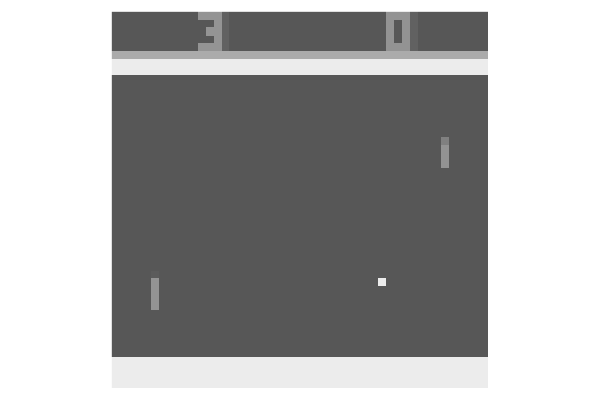

In [21]:
anim_game(test_policy, "pong_before.gif")

and for the trained model:

In [22]:
#using BSON, Zygote, CUDA, Flux

#ps = params(agent.policy)

#BSON.@load "ps.bson" ps 
#ps = gpu(ps)
#Flux.loadparams!(agent.policy,ps)

In [23]:
using JLD2, Flux
using Flux: params

PongNN = JLD2.load("PongNN.jld2", "PongNN")
Flux.loadparams!(test_policy.learner.approximator.model, gpu.(PongNN));

┌ Info: Saved animation to 
└   fn = "/root/Pong/pong_after.gif"


Plots.AnimatedGif("/root/Pong/pong_after.gif")
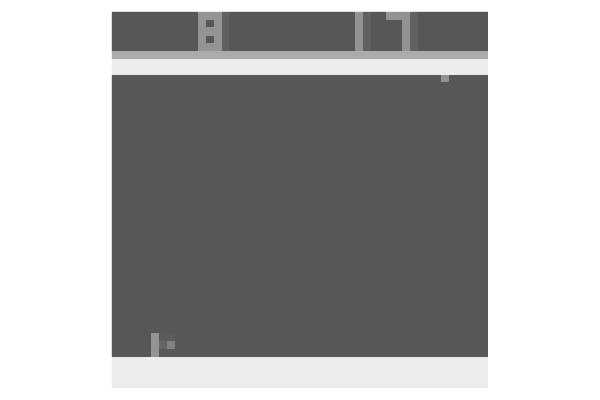

In [28]:
anim_game(test_policy, "pong_after.gif")